In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from xgboost import XGBRegressor
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import catboost as cb
from datetime import datetime
import geopandas as gpd
from scipy.spatial import cKDTree
from shapely.geometry import Point
import numpy as np
from pandas.plotting import scatter_matrix
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
df = pd.read_csv('dataset_for_train.csv')
df.drop(columns=['Unnamed: 0'],inplace=True)
df['dates'] = df['dates'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df_post_crackdown = df.loc[df['dates'] > datetime.strptime('2023-01-15', '%Y-%m-%d'),:]
df_post_crackdown = df_post_crackdown.fillna(0)

In [3]:
mta2 = pd.read_csv('MTA2.csv')
mta2.head()

,zipcode,Full Fare,Senior Citizen / Disabled,7 Day ADA Farecard Access System Unlimited,30 Day ADA Farecard Access System Unlimited,Joint Rail Road Ticket,7 Day Unlimited,30 Day Unlimited,14 Day Reduced Fare Media Unlimited,1 Day Unlimited,...,LIB Special Senior,Rail Road Unlimited No Trade,Transit Check Metrocard Annual Metrocard,Mail and Ride Easy Pay Express,Mail and Ride Unlimited,Path 2 Trip,Airtran Full Fare,Airtran 30 Day,Airtran 10 Trip,Airtran Monthly
0,10000,13220.440000,1140.600000,106.98,193.46,58.280000,4676.480000,7014.900000,62.400000,131.200000,...,144.920,148.08,860.200,511.980000,240.220000,0.000,130.760000,29.100000,0.000000,0.0
1,10001,24610.546667,1714.666667,143.77,302.57,115.776667,7171.893333,9416.676667,39.833333,172.533333,...,254.400,306.74,1076.880,828.866667,318.693333,0.000,329.343333,15.703333,0.006667,0.0
2,10002,12375.880000,1644.860000,98.24,460.98,3.640000,4156.940000,7037.540000,15.600000,133.400000,...,222.480,21.12,904.900,228.740000,130.480000,0.000,154.060000,27.920000,0.000000,0.0
3,10003,9218.780000,886.475000,41.08,246.60,4.630000,2892.480000,5565.800000,31.500000,85.850000,...,78.225,19.19,539.385,245.355000,141.795000,0.005,132.495000,7.890000,0.000000,0.0
4,10004,21483.260000,1365.720000,206.98,414.60,29.300000,8934.780000,9356.280000,83.600000,134.200000,...,205.060,90.52,1388.160,605.640000,227.580000,0.000,337.280000,24.820000,0.060000,0.0


In [4]:
df_final = pd.merge(left=df_post_crackdown, right=mta2, on=["zipcode"], how="inner")

In [5]:
eu = pd.read_csv('energy_use_out.csv')
print(len(eu))
eu.head()

22183


,Latitude,Longitude,Energy
0,40.769272,-73.913633,6811391.5
1,40.790503,-73.967920,21582210.0
2,40.792758,-73.965171,77357080.0
3,40.825608,-73.951062,32088612.0
4,40.837333,-73.940060,20991328.0


In [6]:
eu_gdf = gpd.GeoDataFrame(eu, geometry=gpd.points_from_xy(eu['Longitude'], eu['Latitude']))
gdf_final = gpd.GeoDataFrame(df_final, geometry=gpd.points_from_xy(df_final['longitude'], df_final['latitude']))

In [7]:
file_path = "ZIP_CODE_040114/ZIP_CODE_040114.shp"
nyc_neighborhoods = gpd.read_file(file_path)
nyc_neighborhoods = nyc_neighborhoods.to_crs('EPSG:4326')

In [8]:
for i in eu_gdf.index:
    if len(nyc_neighborhoods.loc[eu_gdf.loc[i,'geometry'].within(nyc_neighborhoods['geometry']), 'ZIPCODE']) > 0:
        eu_gdf.at[i, 'zipcode'] = nyc_neighborhoods.loc[eu_gdf.loc[i,'geometry'].within(nyc_neighborhoods['geometry']), 'ZIPCODE'].iloc[0]

In [9]:
eu_gdf = eu_gdf.dropna()
eu_gdf['zipcode'] = eu_gdf['zipcode'].apply(lambda x: int(x))
by_zcgroup = eu_gdf.groupby('zipcode').mean()
len(by_zcgroup)

183

In [10]:
eu_dict = {}
for i in by_zcgroup.index:
    eu_dict[i] = by_zcgroup.loc[i,'Energy']

In [11]:
for i in gdf_final.index:
    if gdf_final.loc[i,'zipcode'] in eu_dict:
        gdf_final.loc[i,'mean_energy_usage'] = eu_dict[gdf_final.loc[i,'zipcode']]

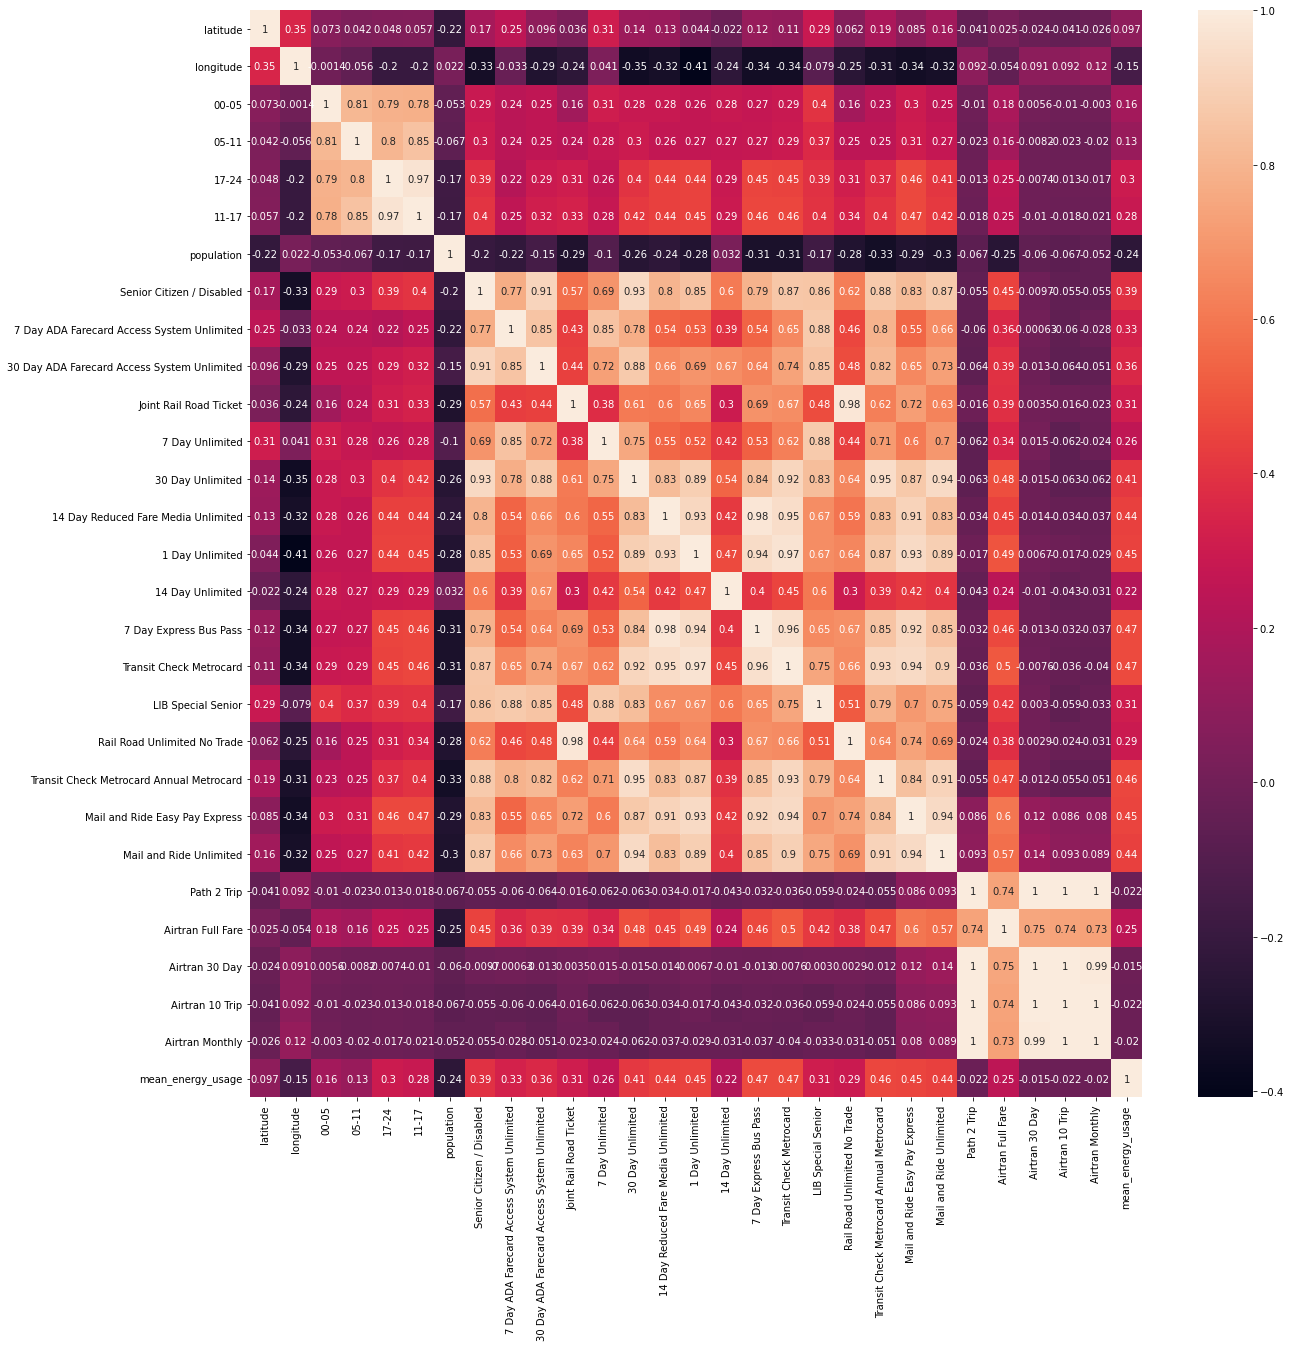

In [12]:
df_ohe = pd.get_dummies(gdf_final, columns=['county','name'])
df_ohe.drop(columns=['station_complex_id','zipcode','geometry'], inplace=True)
df_ohe['month'] = df_ohe['dates'].apply(lambda x: x.month)
df_ohe['weekday'] = df_ohe['dates'].apply(lambda x: x.weekday())
df_ohe = pd.get_dummies(df_ohe, columns=['weekday','month'])
df_ohe.drop(columns=['dates'], inplace=True)

plt.figure(figsize=(20,20))
sns.heatmap(df_ohe[['latitude', 'longitude', '00-05', '05-11', '17-24', '11-17','population', 
                       'Senior Citizen / Disabled',
                       '7 Day ADA Farecard Access System Unlimited',
                       '30 Day ADA Farecard Access System Unlimited', 'Joint Rail Road Ticket',
                       '7 Day Unlimited', '30 Day Unlimited',
                       '14 Day Reduced Fare Media Unlimited', '1 Day Unlimited',
                       '14 Day Unlimited', '7 Day Express Bus Pass', 'Transit Check Metrocard',
                       'LIB Special Senior', 'Rail Road Unlimited No Trade',
                       'Transit Check Metrocard Annual Metrocard',
                       'Mail and Ride Easy Pay Express', 'Mail and Ride Unlimited',
                       'Path 2 Trip', 'Airtran Full Fare', 'Airtran 30 Day', 'Airtran 10 Trip',
                       'Airtran Monthly','mean_energy_usage']].corr(),annot=True)
plt.show()

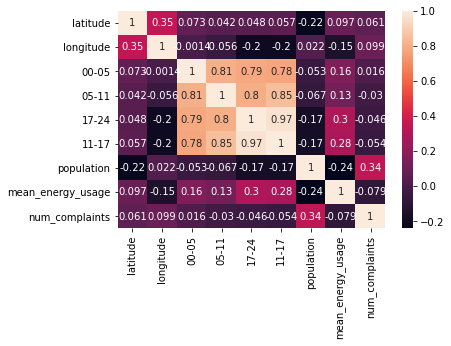


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [13]:
# catboost on post crackdown
df_cat = gdf_final.drop(columns=['station_complex_id','zipcode','geometry'])
df_cat['month'] = df_cat['dates'].apply(lambda x: x.month)
df_cat['weekday'] = df_cat['dates'].apply(lambda x: x.weekday())
num_features = ['latitude','longitude','00-05',	'05-11','17-24','11-17',
                'population','mean_energy_usage','num_complaints']
sns.heatmap(df_cat[num_features].corr(),annot=True)
plt.show()
df_cat.drop(columns=['dates'], inplace=True)
df_cat.drop(columns=['11-17'], inplace=True)
df_ohe = df_ohe.dropna()
y = df_cat['num_complaints']
X = df_cat.drop(columns=['num_complaints'])
X = df_cat[['latitude','longitude','00-05',	'05-11','17-24','population','county',	'name', 'mean_energy_usage']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
remain_num_features = ['latitude', 'longitude', '00-05', '05-11', '17-24', 'population', 
                       'mean_energy_usage']
ss = StandardScaler()
ss.fit(X_train[remain_num_features])
X_train[remain_num_features] = ss.transform(X_train[remain_num_features])
X_test[remain_num_features] = ss.transform(X_test[remain_num_features])

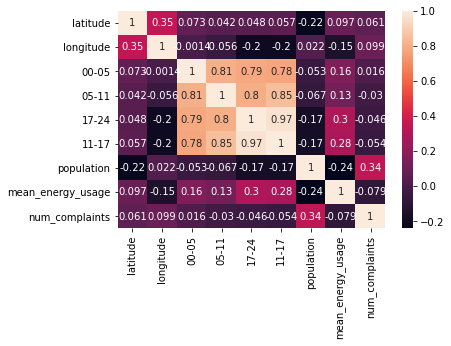


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Learning rate set to 0.485057
0:	learn: 5.2752050	total: 274ms	remaining: 27.1s
1:	learn: 4.5605611	total: 377ms	remaining: 18.5s
2:	learn: 4.2621177	total: 493ms	remaining: 15.9s
3:	learn: 3.9988111	total: 581ms	remaining: 13.9s
4:	learn: 3.8954573	total: 677ms	remaining: 12.9s
5:	learn: 3.8280170	total: 779ms	remaining: 12.2s
6:	learn: 3.7807487	total: 880ms	remaining: 11.7s
7:	learn: 3.7525705	total: 988ms	remaining: 11.4s
8:	learn: 3.7270644	total: 1.1s	remaining: 11.2s
9:	learn: 3.7085903	total: 1.19s	remaining: 10.7s
10:	learn: 3.7013165	total: 1.26s	remaining: 10.2s
11:	learn: 3.6899642	total: 1.35s	remaining: 9.9s
12:	learn: 3.6808603	total: 1.43s	remaining: 9.59s
13:	learn: 3.6725109	total: 1.51s	remaining: 9.3s
14:	learn: 3.6623870	total: 1.59s	remaining: 9.03s
15:	learn: 3.6566346	total: 1.68s	remaining: 8.8s
16:	learn: 3.6464800	total: 1.76s	remaining: 8.59s
17:	learn: 3.6417466	total: 1.86s	remaining: 8.46s
18:	learn: 3.6364378	total: 1.95s	remaining: 8.31s
19:	learn: 3.63

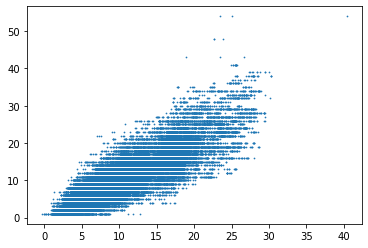

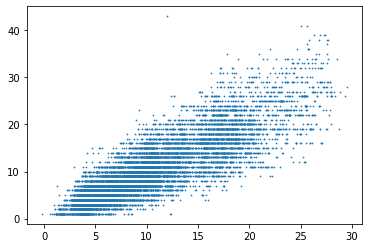

Cat score 0.7113120795666796


In [15]:
# catboost on post crackdown
df_cat = gdf_final.drop(columns=['station_complex_id','zipcode','geometry'])
df_cat['month'] = df_cat['dates'].apply(lambda x: x.month)
df_cat['weekday'] = df_cat['dates'].apply(lambda x: x.weekday())
num_features = ['latitude','longitude','00-05',	'05-11','17-24','11-17',
                'population','mean_energy_usage','num_complaints']
sns.heatmap(df_cat[num_features].corr(),annot=True)
plt.show()
df_cat.drop(columns=['dates'], inplace=True)
df_cat.drop(columns=['11-17'], inplace=True)
df_ohe = df_ohe.dropna()
y = df_cat['num_complaints']
X = df_cat.drop(columns=['num_complaints'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
remain_num_features = ['latitude', 'longitude', '00-05', '05-11', '17-24', 'population', 
                       'Senior Citizen / Disabled',
                       '7 Day ADA Farecard Access System Unlimited',
                       '30 Day ADA Farecard Access System Unlimited', 'Joint Rail Road Ticket',
                       '7 Day Unlimited', '30 Day Unlimited',
                       '14 Day Reduced Fare Media Unlimited', '1 Day Unlimited',
                       '14 Day Unlimited', '7 Day Express Bus Pass', 'Transit Check Metrocard',
                       'LIB Special Senior', 'Rail Road Unlimited No Trade',
                       'Transit Check Metrocard Annual Metrocard',
                       'Mail and Ride Easy Pay Express', 'Mail and Ride Unlimited',
                       'Path 2 Trip', 'Airtran Full Fare', 'Airtran 30 Day', 'Airtran 10 Trip',
                       'Airtran Monthly','mean_energy_usage']
ss = StandardScaler()
ss.fit(X_train[remain_num_features])
X_train[remain_num_features] = ss.transform(X_train[remain_num_features])
X_test[remain_num_features] = ss.transform(X_test[remain_num_features])


my_catboost = cb.CatBoostRegressor(iterations=100, cat_features=['county','name'])
my_catboost.fit(X_train, y_train)
plt.scatter(my_catboost.predict(X_train), y_train,s=0.5)
plt.show()
plt.scatter(my_catboost.predict(X_test), y_test, s=0.5)
plt.show()
print('Cat score',my_catboost.score(X_test, y_test))

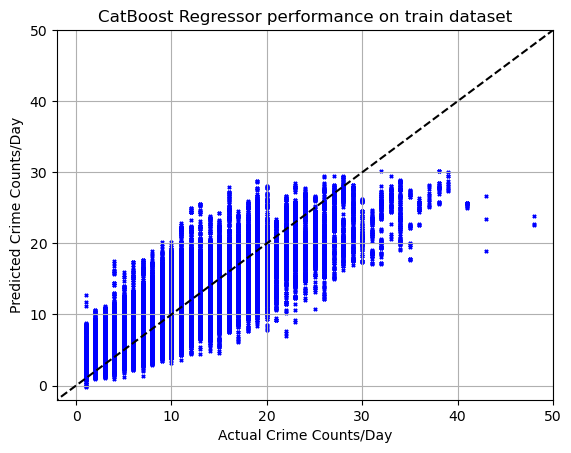

Cat score on Train 0.7382244685615885


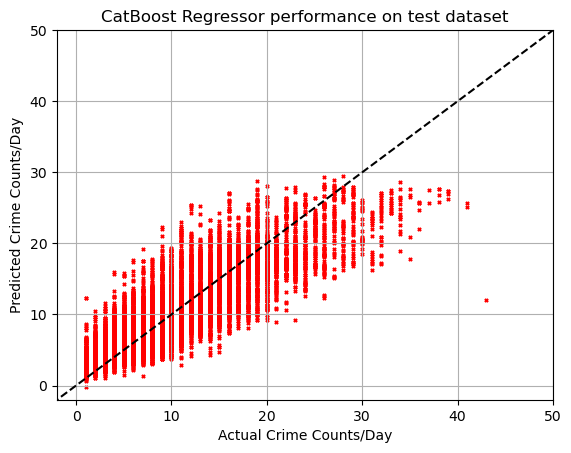

Cat score on Test 0.7113120795666796


In [20]:
plt.scatter(y_train,my_catboost.predict(X_train), s=5, color='b', marker='x')
plt.plot([-10,50],[-10,50], linestyle='--',color='k')
plt.grid()
plt.xlabel('Actual Crime Counts/Day')
plt.ylabel('Predicted Crime Counts/Day')
plt.title('CatBoost Regressor performance on train dataset')
plt.xlim(-2,50)
plt.ylim(-2,50)
plt.show()
print('Cat score on Train',my_catboost.score(X_train, y_train))


plt.scatter(y_test,my_catboost.predict(X_test), s=5, color='r',marker='x')
plt.plot([-10,50],[-10,50], linestyle='--',color='k')
plt.grid()
plt.xlabel('Actual Crime Counts/Day')
plt.ylabel('Predicted Crime Counts/Day')
plt.title('CatBoost Regressor performance on test dataset')
plt.xlim(-2,50)
plt.ylim(-2,50)
plt.show()
print('Cat score on Test',my_catboost.score(X_test, y_test))

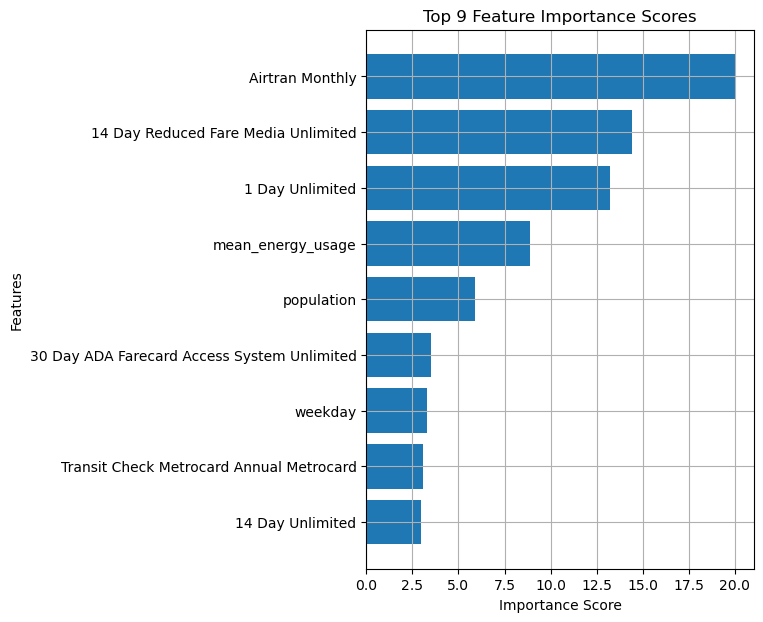

In [21]:
bar_height = my_catboost.feature_importances_
feat_imp_df = pd.DataFrame({'Features': X_train.columns, 'Importance Scores': bar_height})
feat_imp_df = feat_imp_df.sort_values(by='Importance Scores', ascending=True)

how_many=9
plt.figure(figsize=(5,7))
plt.barh(feat_imp_df['Features'][-how_many:], 
         feat_imp_df['Importance Scores'][-how_many:], 
        )
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top {} Feature Importance Scores'.format(how_many))
plt.grid()
plt.show()

In [22]:
shap.initjs()

In [23]:
explainer = shap.TreeExplainer(my_catboost)
shap_values = explainer(X_train)
shap.plots.force(shap_values[0, ...])